# BRDF Representation

## Mitsuba "Deep Dive"

In [111]:
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(mi.variants())
mi.set_variant("llvm_ad_rgb_double")

['scalar_mono', 'scalar_mono_double', 'scalar_rgb', 'scalar_spectral', 'llvm_ad_rgb', 'llvm_ad_rgb_double']


In [112]:
res = 25
azim_vs = np.linspace(0, 2 * np.pi, 2 * res)
zen_vs = np.linspace(0, np.deg2rad(89), res)

incoming = 35
solar_azimuth = 0
wind_speed = 10
wind_direction = np.deg2rad(50)
n_real = 1.333
n_imag = 0.0
chlorinity = 19
pigmentation = 0.3
bsdf = mi.load_dict({
    'type': 'oceanic_legacy',
    'wavelength': 0.5,
    'wind_speed': wind_speed,
    'wind_direction': wind_direction,
    'chlorinity': chlorinity,
    'pigmentation': pigmentation
})
bsdf

OceanicLegacy[
  wavelength = 0.5
  wind_speed = 10
  wind_direction = 0.872665
  chlorinity = 19
  pigmentation = 0.3
]

In [113]:
def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

In [114]:
# Create a dummy surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with X degrees
si.wi = sph_to_eucl(dr.deg2rad(incoming), dr.deg2rad(solar_azimuth))

# Create grid in spherical coordinates and map it into a sphere
res = 500
zeniths_o, azimuths_o = dr.meshgrid(
    dr.linspace(mi.Float, np.deg2rad(1), np.deg2rad(89),     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_eucl(zeniths_o, azimuths_o)

# Evaluate the BSDF
brdf_values = bsdf.eval(mi.BSDFContext(), si, wo)

In [115]:
brdf_np = np.array(brdf_values)

In [116]:
brdf_data = brdf_np[:,0]

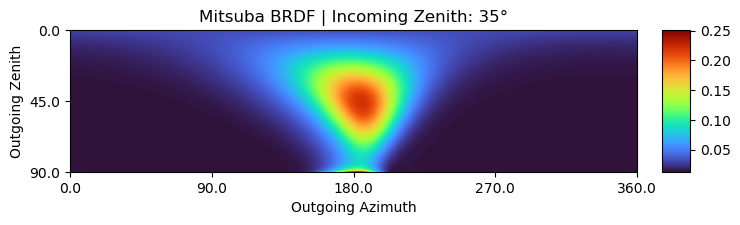

In [117]:
# Extract red channel of BRDF values and reshape into 2D grid
brdf_data = brdf_data.reshape(2 * res, res).T
dimensional_data = brdf_data.T

# Plot values for spherical coordinates
fig, ax = plt.subplots(figsize=(8, 4))

im = ax.imshow(brdf_data, interpolation='spline36', extent=[0, 2 * np.pi, np.pi / 2, 0], cmap='turbo')

# Name the axes
plt.xlabel("Outgoing Azimuth")
plt.ylabel("Outgoing Zenith")

# Add the title
degrees = np.degrees(incoming)

# Round to 2 decimal places
degrees = round(degrees, 2)

# Create x_axis tick labels in degrees
x_ticks = np.linspace(0, 2 * np.pi, 5)
x_labels = np.degrees(x_ticks)
x_labels = [round(label, 2) for label in x_labels]
plt.xticks(x_ticks, x_labels)

# Create y_axis tick labels in degrees
y_ticks = np.linspace(0, np.pi / 2, 3)
y_labels = np.degrees(y_ticks)
y_labels = [round(label, 2) for label in y_labels]
plt.yticks(y_ticks, y_labels)

# Add Title
ax.set_title(f'Mitsuba BRDF | Incoming Zenith: {incoming}°')

# Add color bar with same height as the plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.show()

In [118]:
# Min/Max values
min_val = np.min(brdf_data)
max_val = np.max(brdf_data)
mean_val = np.mean(brdf_data)
mean_exluding_zeros = np.mean(brdf_data[brdf_data != 0])
zeros = np.count_nonzero(brdf_data == 0)

print(f"Min: {min_val}, Max: {max_val}, Mean: {mean_val}, Mean excluding zeros: {mean_exluding_zeros}")
print(f"Zeros: {zeros}, Total: {res * 2 * res}, Percentage: {zeros / (res * 2 * res) * 100}%")

Min: 0.012825300061575904, Max: 0.25099648466171864, Mean: 0.03487531653193925, Mean excluding zeros: 0.03487531653193926
Zeros: 0, Total: 500000, Percentage: 0.0%


## Converting to Polar representation of the BRDF

In [119]:
# Combine zeniths, azimuths and BRDF values into a single array
zeniths = np.array(zeniths_o)
azimuths = np.array(azimuths_o)
brdf_data = np.array(brdf_data).T.flatten()
data = np.stack([zeniths, azimuths, brdf_data], axis=1)

# Remove rows where the zenith (first element) is greater than 90 degrees
data = data[data[:, 0] <= np.pi / 2]

# Extract the new values
zeniths_t = data[:, 0]
azimuths_t = data[:, 1]
brdf_data_t = data[:, 2]

### Simple Polar Plot

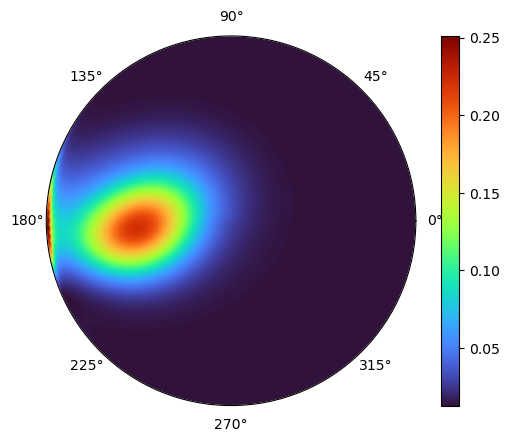

In [120]:
def visualize():
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.scatter(azimuths_t, zeniths_t, c=brdf_data_t, cmap='turbo', s=1)
    ax.grid(False)
    ax.set_yticklabels([])
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')
    ax.set_ylim(0, np.pi / 2)
    plt.show()

visualize()

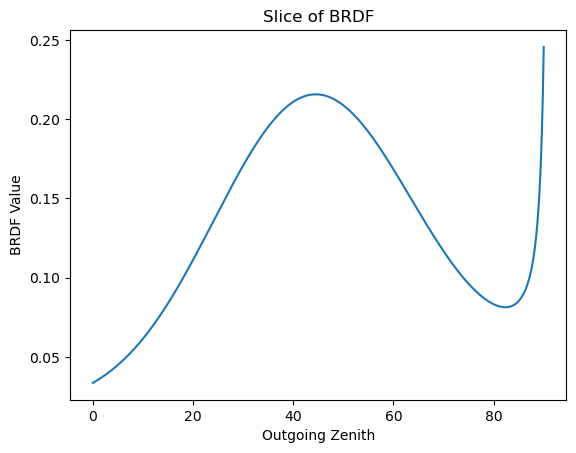

In [121]:
# Visualize a slice of the BRDF
slice_azimuth = np.deg2rad(180)

# Find the index of the slice azimuth
t = slice_azimuth / (2 * np.pi)
slice_index = int(t * 2 * res)

# Extract the slice
slice_data = dimensional_data[slice_index, :]

# Plot the slice
fig, ax = plt.subplots()

# Plot the slice by rescaling the x-axis between 0 and 90 degrees
x = np.linspace(0, np.pi / 2, res)

# X to degrees
x = np.degrees(x)

ax.plot(x, slice_data, label='Slice')
ax.set_xlabel('Outgoing Zenith')
ax.set_ylabel('BRDF Value')
ax.set_title(f'Slice of BRDF')
plt.show()
